# COMP24112 Summative Exercise (30 Marks)
# On Linear Classification and MLP Regression

In this lab exercise, you will build linear classifiers by gradient descent for loan approval classification (14 marks) and build MLP regressors for crop production prediction (16 marks), using two given datasets. To prepare for this lab exercise, you will
* Get familiar with lecture content of Chapters 3-7.
* Get familiar with how to build a regression model by mutlilayer perceptron (MLP) using the scikit learn tutorial (https://scikit-learn.org/stable/modules/neural_networks_supervised.html#regression).
* Get familiar with basic scikit-learn tools for [data splitting](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html), used for setting machine learning experiments.


You will submit a notebook file, a pdf report, and a trained model. You will be marked for implementation, design, result and analysis. Your code should be easy to read and your report should be concise (max 600 words). It is strongly recommended that you use a LaTeX editor, such as [Overleaf](https://www.overleaf.com/), to write your report. Handwritten reports will not be accepted.

Please note your notebook should take no more than 10 minutes to run on a Google Colab instance. **Marks may be dropped for inefficient and unreadable code.**


## 1. Linear Loan Classification (14 marks)
### 1.1 Dataset and Experiment Preparation

**On Dataset**: The provided "Loan Approval Classification Dataset" contains financial and demographic information related to loan applications. It includes 45,000 instances with 14 features, covering applicant demographics, credit history, and loan details, with a mix of categorical (e.g., gender, education, etc) and numerical features (e.g., age, income, etc). You will predict the loan_status variable, which indicates whether a loan application was approved (1) or rejected (0).

**On Data Pre-processing**: This dataset contains categorical featuers which are encoded as text. For our models to interpret these features, it is necessary to preprocess this dataset &mdash; in this case, convert categorical features into one-hot encoding &mdash; by using tools from pandas (https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html). Example code is provided below. 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
import sklearn.model_selection

notebook_start_time = time.time()
loan_data_full = pd.read_csv("loan_data.csv")

# Display a sample of the original dataset, which includes both categorical and numerical features
loan_data_full.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [19]:
# Generate and display summary statistics of the dataset to check key attributes such as sample count, mean, and standard deviation of numerical features
loan_data_full.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [20]:
# Data preprocessing: Convert categorical features into one-hot encoded format
# The categorical features being encoded include: person_gender, person_education, person_home_ownership, loan_intent, and previous_loan_defaults_on_file
loan_data = pd.get_dummies(loan_data_full, columns=['person_home_ownership', 'loan_intent', 'person_education', 'previous_loan_defaults_on_file', 'person_gender'])
# Remove redundant columns to avoid multicollinearity
loan_data = loan_data.drop(columns=['person_gender_male', 'previous_loan_defaults_on_file_No'])

# Display a sample of the dataset after preprocessing
loan_data.head()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_home_ownership_MORTGAGE,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,person_education_Associate,person_education_Bachelor,person_education_Doctorate,person_education_High School,person_education_Master,previous_loan_defaults_on_file_Yes,person_gender_female
0,22.0,71948.0,0,35000.0,16.02,0.49,3.0,561,1,False,...,False,True,False,False,False,False,False,True,False,True
1,21.0,12282.0,0,1000.0,11.14,0.08,2.0,504,0,False,...,False,False,False,False,False,False,True,False,True,True
2,25.0,12438.0,3,5500.0,12.87,0.44,3.0,635,1,True,...,True,False,False,False,False,False,True,False,False,True
3,23.0,79753.0,0,35000.0,15.23,0.44,2.0,675,1,False,...,True,False,False,False,True,False,False,False,False,True
4,24.0,66135.0,1,35000.0,14.27,0.53,4.0,586,1,False,...,True,False,False,False,False,False,False,True,False,False



### 1.2 Model Training and Testing (4 marks)
**On Model and Training Objective Function**: Train a binary linear classifier by minimising a hinge loss with L2 (ridge) regularisation. Specifically, given a set of $N$ training samples $\{(\mathbf{x}_i, y_i)\}_{i=1}^N$, where $\mathbf{x}_i$ is the feature vector and $y_i \in \{-1, +1\}$ is the class label for the $i$-th training sample, the training objective function to minimise is
$$O = C \sum^N_{i=1}\max\left(0, 1 - y_i \left(\mathbf{w}^T\mathbf{x}_i + w_0\right)\right) + \frac{1}{2}\mathbf{w}^T\mathbf{w}. $$
Here, $\mathbf{w}$ is a column weight vector of the linear model, $w_0$ is the bias parameter of the model, and $C$ is the regularisation hyperparameter.

**Instruction for Implementing `linear_gd_train`**: Complete the implementation of the training function `linear_gd_train` below, which trains a linear model by minimising the above training loss using gradient descent. The function should return the trained model weights and the corresponding objective function value per iteration. In addition to the training data, the function should take the regularisation hyperparameter $C$, learning rate $\eta$, and the number of iterations $N_{max}$ as arguments. A reasonably good setting of these parameters has been provided below. *Marking notes: Scikit-learn and PyTorch are NOT allowed for implementating* `linear_gd_train`*. You should avoid using* `for` *loops in your implementation of the objective function or weight update, and instead use built-in numpy operations for efficiency.*

In [21]:
def linear_gd_train(data, labels, C=0.2, n_iters=200, learning_rate=0.0001, random_state=None):
    """
    Trains a linear classifier using gradient descent with hinge loss and L2 regularization.

    data: training data
    labels: training labels (boolean)
    c: regularisation parameter
    n_iters: number of iterations
    learning_rate: learning rate for gradient descent

    Returns an array of cost and model weights per iteration.
    """
    rng = np.random.default_rng(seed=random_state)

    # Add bias column to input
    X_tilde = np.hstack([np.ones((data.shape[0], 1)), data])  # shape (N, D+1)
    y = labels * 2 - 1  # Convert from {0,1} to {-1,1}

    # Initialize weights (including bias term)
    w = rng.standard_normal(X_tilde.shape[1])
    
    w_all = []
    cost_all = []

    for _ in range(n_iters):
        margins = y * np.dot(X_tilde, w)
        hinge_losses = np.maximum(0, 1 - margins)
        cost = C * np.mean(hinge_losses) + 0.5 * np.dot(w[1:], w[1:])  # exclude bias from reg

        # Compute gradient
        mask = (margins < 1).astype(float)
        grad = -C * np.dot((y * mask), X_tilde) / len(y)
        grad[1:] += w[1:]  # regularize weights (not bias)

        # Update weights
        w = w - learning_rate * grad

        # Track progress
        w_all.append(w.copy())
        cost_all.append(cost)

    return cost_all, w_all, w
def linear_predict(data, w):
    """
    Predicts binary labels using trained linear model weights.

    data: test data
    w: learnt weights

    Returns an array of model predictions
    """
    X_tilde = np.hstack([np.ones((data.shape[0], 1)), data])  # add bias
    y_pred = np.dot(X_tilde, w)
    return (y_pred > 0).astype(int)  # convert back to {0,1}


**On Data Splitting**: Use the provided code below to split the data into training and testing sets.

In [22]:
from sklearn.preprocessing import StandardScaler

# Separate the features and target variable
binary_features = loan_data.drop(columns=['loan_status'])
binary_targets = loan_data['loan_status']

# Named _cls to keep our classification experiments distinct from regression
train_X_cls, test_X_cls, train_y_cls, test_y_cls = sklearn.model_selection.train_test_split(binary_features, binary_targets, test_size=0.15, stratify=binary_targets)

# Standardise the data
scaler = StandardScaler()

train_X_cls = scaler.fit_transform(train_X_cls)

In [23]:
# 4. Standardize the test set
test_X_cls = scaler.transform(test_X_cls)

In [24]:
print(type(train_X_cls))
print(type(test_X_cls))
print(type(train_y_cls))
print(type(test_y_cls))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [25]:
#check data type


train_y_cls = train_y_cls.to_numpy()
test_y_cls = test_y_cls.to_numpy()

print(type(train_X_cls))
print(type(test_X_cls))
print(type(train_y_cls))
print(type(test_y_cls))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


**Instruction for Classification Experiment**: Write your code below to (1) train the model, (2) plot the training objective function value and the classification accuracy of the training set over iterations, and (3) print the classification accuracy and $F_1$ score of the testing set. Use the default setting provided in `linear_gd_train` for $C$, $\eta$ and $N_{max}$. Your plot should have axis labels and titles.

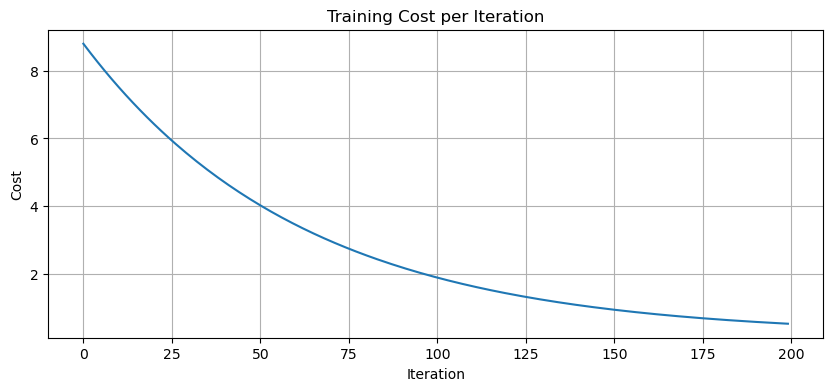

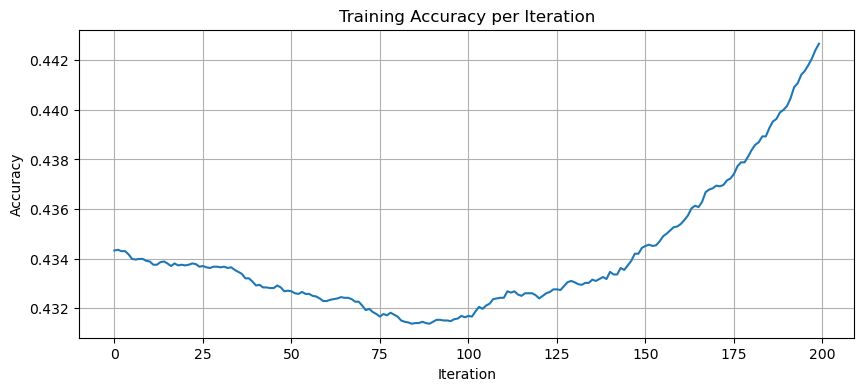

Training Accuracy: 0.4427
Test Accuracy: 0.4514
Test F1 Score 1: 0.3365


In [33]:
# Custom F1 score function 
def f1_score_custom(y_true, y_pred):
    """
    Parameters:
    - y_true: list or array of true labels
    - y_pred: list or array of predicted labels

    Returns:
    - F1 score: float
    """
    # Count TP, FP, FN
    tp = sum((yt == 1 and yp == 1) for yt, yp in zip(y_true, y_pred))
    fp = sum((yt == 0 and yp == 1) for yt, yp in zip(y_true, y_pred))
    fn = sum((yt == 1 and yp == 0) for yt, yp in zip(y_true, y_pred))
    
    # Handle edge cases
    if tp + fp == 0 or tp + fn == 0:
        return 0.0  # Avoid division by zero
    
    # Precision and Recall
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    # F1 Score
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

# accuracy score function 
def accuracy_score_custom(y_true, y_pred):
    """
    Parameters:
    - y_true: list or array of true labels
    - y_pred: list or array of predicted labels

    Returns:
    - accuracy: float, the proportion of correct predictions
    """
    if len(y_true) != len(y_pred):
        raise ValueError("Length of y_true and y_pred must be the same")

    correct = sum(yt == yp for yt, yp in zip(y_true, y_pred))
    accuracy = correct / len(y_true)
    return accuracy


# Train the model
cost_all, w_all, w_final = linear_gd_train(
    train_X_cls, train_y_cls, C=0.2, n_iters=200, learning_rate=0.008, random_state=42
)

# Plot cost per iteration
plt.figure(figsize=(10, 4))
plt.plot(cost_all)
plt.title("Training Cost per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

# Plot training accuracy per iteration
acc_train = []
for w in w_all:
    y_pred_train = linear_predict(train_X_cls, w)
    acc_train.append(accuracy_score_custom(train_y_cls, y_pred_train))

plt.figure(figsize=(10, 4))
plt.plot(acc_train)
plt.title("Training Accuracy per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Predict on test set
y_pred_test = linear_predict(test_X_cls, w_final)

# Evaluate
test_accuracy = accuracy_score_custom(test_y_cls, y_pred_test)
test_f1 = f1_score_custom(test_y_cls, y_pred_test)

print(f"Training Accuracy: {acc_train[-1]:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score 1: {test_f1:.4f}")





We will do the same now but now we will see how a bigger learning reate makes the accuracy curve smoother

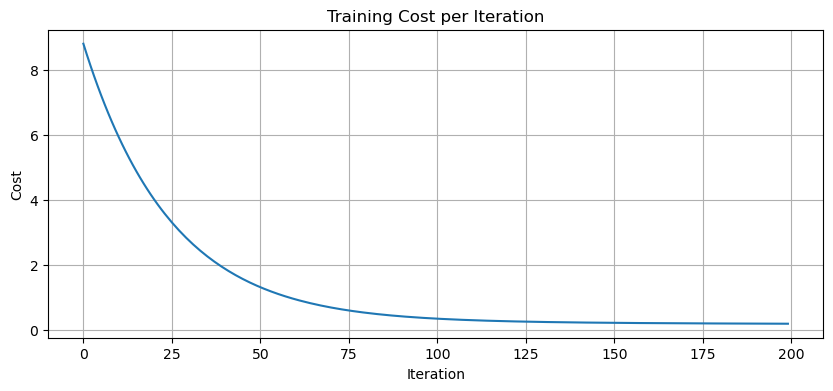

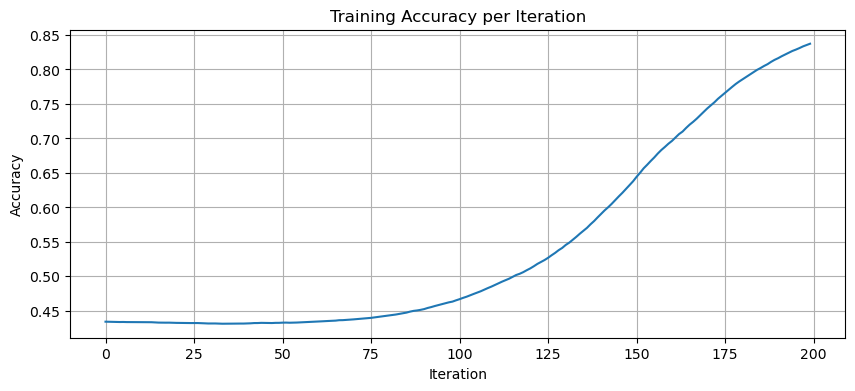

Test Accuracy: 0.8373
Test Accuracy: 0.8433
Test F1 Score 1: 0.6944


In [27]:
# Train the model
cost_all, w_all, w_final = linear_gd_train(
    train_X_cls, train_y_cls, C=0.2, n_iters=200, learning_rate=0.02, random_state=42
)

# Plot cost per iteration
plt.figure(figsize=(10, 4))
plt.plot(cost_all)
plt.title("Training Cost per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

# Plot training accuracy per iteration
acc_train = []
for w in w_all:
    y_pred_train = linear_predict(train_X_cls, w)
    acc_train.append(accuracy_score_custom(train_y_cls, y_pred_train))

plt.figure(figsize=(10, 4))
plt.plot(acc_train)
plt.title("Training Accuracy per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Predict on test set
y_pred_test = linear_predict(test_X_cls, w_final)

# Evaluate
test_accuracy = accuracy_score_custom(test_y_cls, y_pred_test)
test_f1 = f1_score_custom(test_y_cls, y_pred_test)

print(f"Training Accuracy: {acc_train[-1]:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score 1: {test_f1:.4f}")



#### 1.3 Learning Rate Analysis (4 marks)
The learning rate $\eta$ (Greek letter "eta") is a key parameter that affects the model training and performance. Design an appropriate experiment to demonstrate the effect of $\eta$ on model training, and on the model performance during testing.

In [30]:
# Define learning rates and number of iterations to explore
learning_rates = [0.001, 0.004, 0.008, 0.02, 0.05]
n_iters = 200

# Dictionary to store training results for each learning rate
results = {}

# Loop over each learning rate
for eta in learning_rates:
    print(f"\nTraining with learning rate η = {eta}")

    # Train the model using gradient descent
    cost_all, w_all, w_final = linear_gd_train(
        train_X_cls, train_y_cls,
        C=0.2,
        n_iters=n_iters,
        learning_rate=eta,
        random_state=42
    )

    # Compute training accuracy for every iteration (this is slow but only done here to be used for plotting below)
    acc_train = [
        accuracy_score_custom(train_y_cls, linear_predict(train_X_cls, w))
        for w in w_all
    ]

    # Predict on the test set using final weights
    y_pred_test = linear_predict(test_X_cls, w_final)

    # Evaluate model on test set
    acc_test = accuracy_score_custom(test_y_cls, y_pred_test)
    f1_test = f1_score_custom(test_y_cls, y_pred_test)

    # Store results for this learning rate
    results[eta] = {
        "cost": cost_all,
        "acc_train": acc_train,
        "acc_test": acc_test,
        "f1_test": f1_test
    }

    # Print key metrics for immediate visibility
    print(f"| Training Accuracy:  {acc_train[-1]:.4f} | Test Accuracy: {acc_test:.4f} | Test F1 Score: {f1_test:.4f}")



Training with learning rate η = 0.001
| Training Accuracy:  0.4337 | Test Accuracy: 0.4412 | Test F1 Score: 0.2870

Training with learning rate η = 0.004
| Training Accuracy:  0.4317 | Test Accuracy: 0.4412 | Test F1 Score: 0.3033

Training with learning rate η = 0.008
| Training Accuracy:  0.4427 | Test Accuracy: 0.4514 | Test F1 Score: 0.3365

Training with learning rate η = 0.02
| Training Accuracy:  0.8373 | Test Accuracy: 0.8433 | Test F1 Score: 0.6944

Training with learning rate η = 0.05
| Training Accuracy:  0.7778 | Test Accuracy: 0.7778 | Test F1 Score: 0.0000


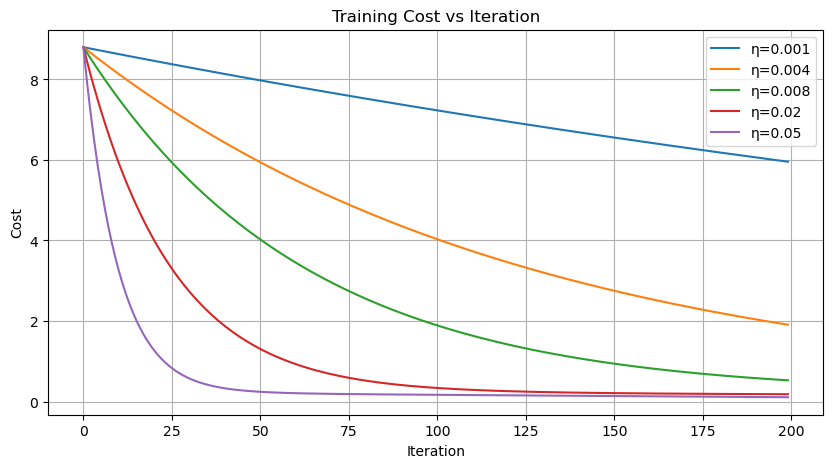

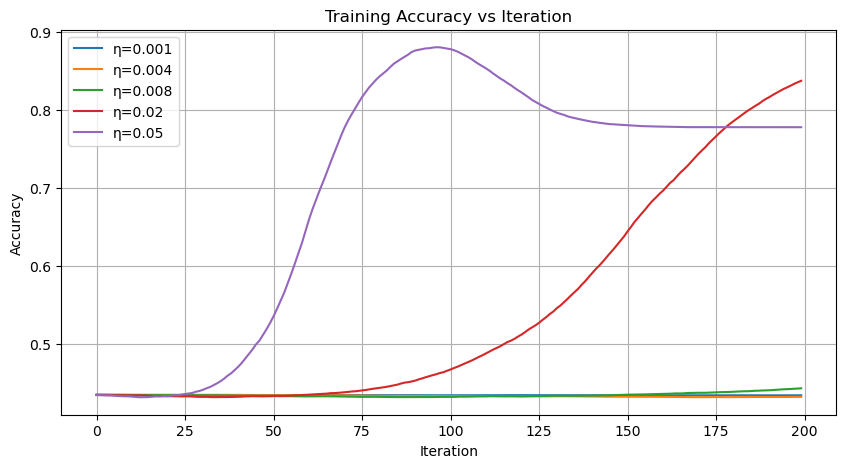

In [31]:
# Plot training cost per iteration
plt.figure(figsize=(10, 5))
for eta in learning_rates:
    plt.plot(results[eta]["cost"], label=f"η={eta}")
plt.title("Training Cost vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()
plt.grid(True)
plt.show()

# Plot training accuracy per iteration
plt.figure(figsize=(10, 5))
for eta in learning_rates:
    plt.plot(results[eta]["acc_train"], label=f"η={eta}")
plt.title("Training Accuracy vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# Grid Search Experiment: Exploring Effects of Learning Rate (η) and Regularization Strength (C)

In this experiment, we perform a grid search to evaluate how combinations of learning rate **η** and regularization strength **C** affect model performance on the test set. The goal is to identify the optimal configuration that maximizes both **accuracy** and **F1 score**, which is especially important when dealing with imbalanced classification problems.

## 1. Objective Function
In a Support Vector Machine (SVM) for binary classification, the parameter \( C \) controls the trade-off between maximizing the margin and minimizing classification errors. The objective function is:

$$O = C \sum^N_{i=1}\max\left(0, 1 - y_i \left(\mathbf{w}^T\mathbf{x}_i + w_0\right)\right) + \frac{1}{2}\mathbf{w}^T\mathbf{w}. $$

- The first term (hinge loss) penalizes misclassifications.
- The second term encourages a larger margin.
- \( C \) balances these two objectives.

## 2. Dataset Context
In our situation we have an imbalanced binary classification dataset with:
- **80% majority class**
- **20% minority class**

This imbalance impacts how \( C \) affects performance metrics like accuracy and F1 score.

## 3. Learning rate (η)

It Controls convergence speed. Too small results in slow learning; too large can cause instability or divergence.

## 4. Expected Variation in Accuracy with \( C \)
Accuracy measures the proportion of correct predictions but is biased toward the majority class in imbalanced data.

- **Low \( C \)**:
  - Prioritizes a larger margin, allowing more misclassifications.
  - Likely to misclassify minority class instances.
  - **Expectation**: High accuracy (~80% or more) because the majority class dominates.
- **High \( C \)**:
  - Focuses on minimizing misclassifications, fitting the minority class better.
  - May misclassify some majority class instances.
  - **Expectation**: Accuracy may decrease slightly but remains high due to the 80% majority class.

**Trend**: Starts high at low \( C \), slightly decreases or stabilizes as \( C \) increases.

## 5. Expected Variation in F1 Score with \( C \)
F1 score (harmonic mean of precision and recall) better reflects minority class performance.

- **Low \( C \)**:
  - Larger margin leads to fewer minority class predictions.
  - **Low recall**: Misses many minority instances.
  - **Moderate precision**: Minority predictions may be accurate but sparse.
  - **Expectation**: Low F1 score due to poor recall.
- **High \( C \)**:
  - Fits the minority class better.
  - **Higher recall**: Captures more minority instances.
  - **Lower precision**: May increase false positives.
  - **Expectation**: F1 score increases until overfitting occurs, then may plateau or drop.

In short, a larger C allows the model to focus more on placing the decision boundary correctly such that to classify the points accurately, while placing less importance on the margin size.

**Trend**: Starts low at low \( C \), rises with \( C \), peaks at an optimal \( C \), then may decline if \( C \) is too high.

## 6. Summary
- **Accuracy**: Remains high (~80%) across \( C \) values due to the imbalanced dataset but may dip slightly at high \( C \).
- **F1 Score**: Improves with increasing \( C \) as minority class performance improves, but excessive \( C \) risks overfitting.

This understanding helps guide hyperparameter tuning for SVMs on imbalanced datasets, prioritizing F1 score for better minority class performance.

In [37]:
# Define the values of regularization strength C and learning rate η to search over
C_values = [0.1, 0.2, 0.5, 1, 3, 5, 10, 20, 10000]
eta_values = [0.004, 0.008, 0.02, 0.04, 0.09, 0.1]

# Store results for each (C, η) combination
results = []

# Perform grid search: loop over each combination of C and η
for C in C_values:
    for eta in eta_values:
        # Train the model with current C and η values
        cost_all, w_all, w_final = linear_gd_train(
            train_X_cls, train_y_cls,
            C=C,
            n_iters=200,
            learning_rate=eta,
            random_state=42  # Ensures reproducibility
        )

        # Predict on the test set
        y_pred = linear_predict(test_X_cls, w_final)

        # Evaluate the model using custom accuracy and F1 functions
        acc = accuracy_score_custom(test_y_cls, y_pred)
        f1 = f1_score_custom(test_y_cls, y_pred)

        # Print the results for immediate observation
        print(f"C={C}, η={eta} → Accuracy={acc:.4f}, F1={f1:.4f}")

        results.append((C, eta, acc, f1))


C=0.1, η=0.004 → Accuracy=0.4317, F1=0.2977
C=0.1, η=0.008 → Accuracy=0.4156, F1=0.3213
C=0.1, η=0.02 → Accuracy=0.4130, F1=0.4286
C=0.1, η=0.04 → Accuracy=0.8714, F1=0.6216
C=0.1, η=0.09 → Accuracy=0.7778, F1=0.0000
C=0.1, η=0.1 → Accuracy=0.7778, F1=0.0000
C=0.2, η=0.004 → Accuracy=0.4412, F1=0.3033
C=0.2, η=0.008 → Accuracy=0.4514, F1=0.3365
C=0.2, η=0.02 → Accuracy=0.8433, F1=0.6944
C=0.2, η=0.04 → Accuracy=0.7782, F1=0.0040
C=0.2, η=0.09 → Accuracy=0.7778, F1=0.0000
C=0.2, η=0.1 → Accuracy=0.7778, F1=0.0000
C=0.5, η=0.004 → Accuracy=0.4708, F1=0.3194
C=0.5, η=0.008 → Accuracy=0.5831, F1=0.4088
C=0.5, η=0.02 → Accuracy=0.8074, F1=0.2362
C=0.5, η=0.04 → Accuracy=0.7778, F1=0.0000
C=0.5, η=0.09 → Accuracy=0.7778, F1=0.0000
C=0.5, η=0.1 → Accuracy=0.7778, F1=0.0000
C=1, η=0.004 → Accuracy=0.5244, F1=0.3489
C=1, η=0.008 → Accuracy=0.7830, F1=0.5708
C=1, η=0.02 → Accuracy=0.7784, F1=0.0053
C=1, η=0.04 → Accuracy=0.7778, F1=0.0000
C=1, η=0.09 → Accuracy=0.7778, F1=0.0000
C=1, η=0.1 → Acc

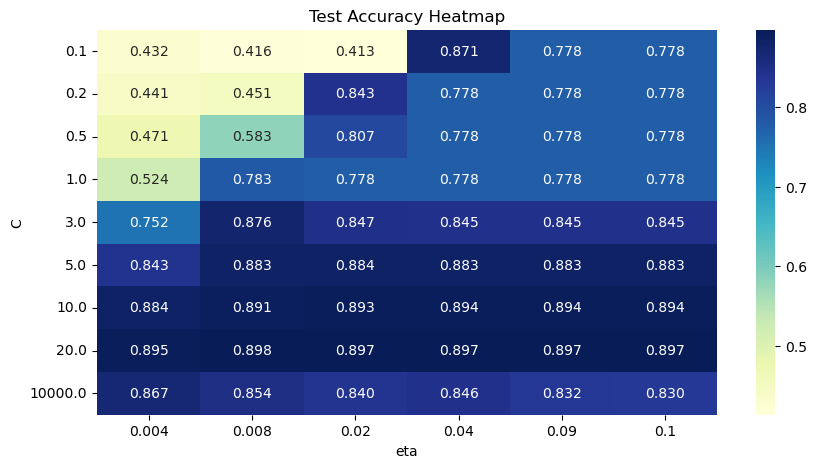

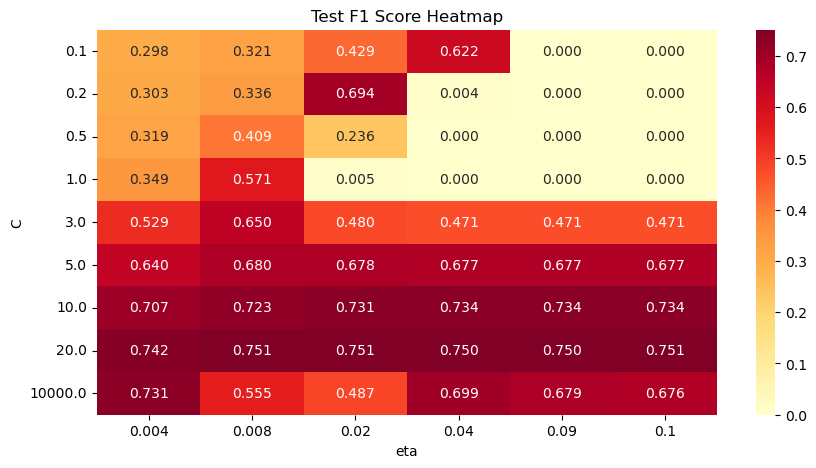

In [38]:
results_df = pd.DataFrame(results, columns=["C", "eta", "accuracy", "f1"])
# Pivot the table to plot heatmaps

import seaborn as sns
import matplotlib.pyplot as plt
acc_pivot = results_df.pivot(index="C", columns="eta", values="accuracy")
f1_pivot = results_df.pivot(index="C", columns="eta", values="f1")

# Plot accuracy heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(acc_pivot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Test Accuracy Heatmap")
plt.show()

# Plot F1 score heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(f1_pivot, annot=True, fmt=".3f", cmap="YlOrRd")
plt.title("Test F1 Score Heatmap")
plt.show()


### 7. Results vs. Expectations Summary

####  Accuracy (Test Accuracy Heatmap)
- As expected, **accuracy remains high across most combinations**, mainly due to the dataset's imbalance (80% majority class).
- **Low C and low η** (top-left corner of the heatmap) result in poor accuracy, indicating underfitting or failure to learn meaningful patterns.
- **Moderate to high C values** (e.g., C = 5 to C = 20) with moderate η (0.02–0.04) yield the **best accuracy**, matching the predicted sweet spot between margin size and model flexibility.
- **Extremely high C** (e.g., 10000) maintains good accuracy but does not significantly improve performance beyond C = 20, showing **diminishing returns**.

####  F1 Score (Test F1 Score Heatmap)
- F1 scores are **very low at low C**, particularly with high η, confirming the expectation that the minority class is poorly handled under stronger regularization.
- **As C increases**, F1 scores improve substantially, peaking around **C = 10–20** and **η = 0.02**, where precision and recall for the minority class are balanced.
- **Extremely high C** (e.g., 10000) does not immediately degrade performance, but starts showing slight F1 decline as expected,

---

###  Interpretation
These outcomes align well with theoretical expectations:
- **Accuracy** remains relatively stable and biased by the majority class, offering limited insight in imbalanced settings.
- **F1 Score**, being more sensitive to minority class performance, provides clearer differentiation between good and poor model configurations.
- The **optimal configuration zone** lies around **moderate-to-high C** and **moderate η** (e.g., C = 10–20, η = 0.02–0.04).

These results validate the need for careful hyperparameter tuning when dealing with imbalanced datasets and reinforce the importance of using **F1 score** over accuracy in such contexts.


In [36]:
#compare with logistic  regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Train logistic regression model
log_reg = LogisticRegression(
    penalty='l2',
    C=10,            # Regularization strength, similar to SVM models
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
log_reg.fit(train_X_cls, train_y_cls)


y_pred_log = log_reg.predict(test_X_cls)


log_acc = accuracy_score(test_y_cls, y_pred_log)
log_f1 = f1_score(test_y_cls, y_pred_log)

print(f"Logistic Regression - Accuracy: {log_acc:.4f}, F1 Score: {log_f1:.4f}")


Logistic Regression - Accuracy: 0.8997, F1 Score: 0.7704


It is good to see that a different machine learning model implemented from an existing library has the same performance as ours implemented from scratch.

### 1.4 Report (6 Marks)
1. Summarize (1) your process of constructing the loss function and computing its gradient used by `linear_gd_train`, (2) how your Python implementation minimizes this function, and (3) key insights learned from the task. (*3 marks*)
2. Draw conclusions about your model behaviour and data from your plot produced in Section 1.2 based on classification accuracies of your training and testing sets? (*1 mark*)
3. Discuss the effect of η on model training and on testing performance, based on your observations obtained in Section 1.3. (*2 marks*)

## 2. Soybean Production Prediction by MLP (16 marks)
###  2.1 Dataset and Experiment Preparation

**On Dataset**: The provided "Soybean Agricultural Dataset" contains agricultural parameters related to soybean plant growth and production. It includes 52,678 instances with 13 features, covering plant characteristics, environmental conditions, and treatment factors, such as genotype, salicylic acid treatment, water stress, plant height, number of pods, chlorophyll content, etc. You will build a regression model by MLP to predict the soybean production, which reflects the crop yield under different experimental conditions.

**On Data Pre-processing**: This dataset also needs pre-processing. Example code on conducting one-hot encoding to convert string features to numerical values is provided below. Further pre-processing techniques are provided by Scikit-Learn data pre-processing tools (https://scikit-learn.org/stable/modules/preprocessing.html), which you will use later.

In [2]:
from sklearn.preprocessing import OneHotEncoder

# Read data
soybean_data_full = pd.read_csv("soybean_data.csv")

# Display a sample of the original dataset
soybean_data_full.head()

,Parameters,Random,Plant Height (PH),Number of Pods (NP),Biological Weight (BW),Sugars (Su),Relative Water Content in Leaves (RWCL),ChlorophyllA663,Chlorophyllb649,Protein Percentage (PPE),Weight of 300 Seeds (W3S),Leaf Area Index (LAI),Seed Yield per Unit Area (SYUA),Number of Seeds per Pod (NSP),Protein Content (PCO)
0,C1S1G5,R1,50.5,130.3,111.0,0.433,0.732,1.4,3.1,33.2,33.6,0.08,5567.4,1.86,0.82
1,C2S3G4,R1,44.5,132.0,80.0,0.334,0.674,7.1,2.2,38.5,34.4,0.09,2245.5,1.87,0.13
2,C2S1G6,R1,52.2,150.0,83.0,0.490,0.677,1.8,1.3,33.6,35.2,0.07,4326.7,2.04,0.15
3,C1S1G1,R1,50.5,140.8,66.0,0.163,0.745,1.1,3.0,33.5,52.3,0.09,6214.5,2.20,0.14
4,C2S2G6,R2,52.0,136.0,62.0,0.265,0.633,4.3,1.2,33.5,44.4,0.07,3985.2,2.06,0.30


In [3]:
# Get and display all unique values from the 'Parameters' column to identify distinct experimental conditions
soybean_data_full['Parameters'].unique()

# NOTE: The 'Parameters' column is a string encoding experimental conditions.
# We need to extract numerical values from this string and create separate columns for each parameter.
# Then, we will apply one-hot encoding to categorical variables to prepare the data for machine learning models.
# G: Refers to the genotype of soybean, consisting of six different genotypes.
# C: Represents salicylic acid, which has two levels (250 mg and 450 mg), along with a third level as a standard control.
# S: Indicates water stress, which includes two levels:
#       - Water stress at 5% of field capacity.
#       - Water stress at 70% of field capacity.

array(['C1S1G5', 'C2S3G4', 'C2S1G6', 'C1S1G1', 'C2S2G6', 'C1S1G6',
       'C1S3G5', 'C2S2G4', 'C2S3G1', 'C1S1G2', 'C1S3G4', 'C2S3G3',
       'C2S1G2', 'C1S3G1', 'C2S2G5', 'C2S2G1', 'C1S3G2', 'C2S1G1',
       'C2S3G2', 'C1S2G1', 'C2S1G3', 'C1S2G4', 'C1S2G6', 'C1S1G4',
       'C2S2G2', 'C1S1G3', 'C2S3G5', 'C1S2G3', 'C2S1G4', 'C2S1G5',
       'C2S3G6', 'C1S2G2', 'C1S3G6', 'C1S3G3', 'C1S2G5'], dtype=object)

In [4]:
# Extract the individual parameters from the 'parameters' column
soybean_data_processed = soybean_data_full.copy()
# Extract the genotype and one-hot encode it
encoder = OneHotEncoder()
genotypes = encoder.fit_transform(soybean_data_full['Parameters'].str.extract(r'G(\d)')).toarray()
soybean_data_processed = pd.concat([soybean_data_processed, pd.DataFrame(genotypes, columns=[f'G{i}' for i in range(1, 7)])], axis=1)

# Extract the salicylic acid treatment and encode it as 0, 250 mg, or 450 mg
# 1 = 250 mg, 2 = 450 mg, 3 = control
salicylic_acid = soybean_data_full['Parameters'].str.extract(r'C(\d+)').astype(float)
salicylic_acid = salicylic_acid.replace({1: 250, 2: 450, 3: 0})
soybean_data_processed['Salicylic acid (mg)'] = salicylic_acid

# Extract the water stress treatment and encode it as .05 or .7 of field capacity
water_stress = soybean_data_full['Parameters'].str.extract(r'S(\d)').astype(float)
water_stress = water_stress.replace({1: .05, 2: .7})
soybean_data_processed['Water Stress (pct field capacity)'] = water_stress

# Drop the original 'Parameters' column as well as 'Random' column
soybean_data_processed.drop(columns=['Parameters', 'Random '], inplace=True)

# Display a sample of the dataset after preprocessing
soybean_data_processed.head()

,Plant Height (PH),Number of Pods (NP),Biological Weight (BW),Sugars (Su),Relative Water Content in Leaves (RWCL),ChlorophyllA663,Chlorophyllb649,Protein Percentage (PPE),Weight of 300 Seeds (W3S),Leaf Area Index (LAI),...,Number of Seeds per Pod (NSP),Protein Content (PCO),G1,G2,G3,G4,G5,G6,Salicylic acid (mg),Water Stress (pct field capacity)
0,50.5,130.3,111.0,0.433,0.732,1.4,3.1,33.2,33.6,0.08,...,1.86,0.82,0.0,0.0,0.0,0.0,1.0,0.0,250.0,0.05
1,44.5,132.0,80.0,0.334,0.674,7.1,2.2,38.5,34.4,0.09,...,1.87,0.13,0.0,0.0,0.0,1.0,0.0,0.0,450.0,3.00
2,52.2,150.0,83.0,0.490,0.677,1.8,1.3,33.6,35.2,0.07,...,2.04,0.15,0.0,0.0,0.0,0.0,0.0,1.0,450.0,0.05
3,50.5,140.8,66.0,0.163,0.745,1.1,3.0,33.5,52.3,0.09,...,2.20,0.14,1.0,0.0,0.0,0.0,0.0,0.0,250.0,0.05
4,52.0,136.0,62.0,0.265,0.633,4.3,1.2,33.5,44.4,0.07,...,2.06,0.30,0.0,0.0,0.0,0.0,0.0,1.0,450.0,0.70


In [5]:
# Generate and display summary statistics of the dataset to check key attributes such as sample count, mean, and standard deviation of numerical features
soybean_data_full.describe()

,Plant Height (PH),Number of Pods (NP),Biological Weight (BW),Sugars (Su),Relative Water Content in Leaves (RWCL),ChlorophyllA663,Chlorophyllb649,Protein Percentage (PPE),Weight of 300 Seeds (W3S),Leaf Area Index (LAI),Seed Yield per Unit Area (SYUA),Number of Seeds per Pod (NSP),Protein Content (PCO)
count,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000
mean,49.962588,144.938631,114.555298,0.477444,0.673589,3.937433,2.399918,36.039840,35.342259,0.072110,4388.373900,2.020035,0.507945
std,3.052511,19.984197,48.927013,0.236289,0.084562,2.844534,1.189726,2.417536,4.989765,0.022296,1251.716467,0.246010,0.287692
min,40.400000,75.000000,32.000000,0.161000,0.434000,1.000000,1.100000,31.100000,26.400000,0.020000,2127.500000,1.400000,0.120000
25%,49.200000,130.400000,80.000000,0.294250,0.633000,1.500000,1.300000,33.600000,32.200000,0.050000,3352.200000,1.850000,0.330000
50%,50.300000,147.000000,102.000000,0.463000,0.677000,2.400000,2.200000,36.600000,34.500000,0.080000,4300.700000,2.050000,0.480000
75%,52.000000,158.000000,132.750000,0.612000,0.723000,6.700000,3.100000,38.000000,37.200000,0.090000,5233.500000,2.200000,0.600000
max,55.700000,218.000000,236.000000,1.115000,0.875000,10.200000,7.800000,39.900000,53.900000,0.100000,7841.500000,2.600000,1.800000



### 2.2 MLP Model Selection (4 marks)
This exercise focuses on the practical usage and implementation of MLPs. Key hyper-parameters that can affect the MLP performance include model architecture, activation function, and the number of training iterations.

**Instruction on MLP Model Options**: You should experiment with the following model options.

* *MLP architectures* including two single-hidden-layer MLPs, one with 3 hidden neurons (small) and another with 100 hidden neurons (large), and two two-hidden-layer MLPs, one with (3,3) neurons (small) and another with (100,100) neurons (large).
* *Activation functions* including the logistic and ReLU activations.
* *Numbers of training iterations* including three different iteration numbers.

Model variations resulted from the above configurations are defined in the 'param_grid' below. All other hyperparameters follow Scikit-Learn’s default settings.


In [6]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'hidden_layer_sizes': [(3,), (100,), (3, 3), (100, 100)],
        'activation': ['relu', 'logistic'],
        'max_iter': [50, 200, 500]
    },
]

Split the dataset into the training and testing sets. 

In [7]:
# Define regression target and features, perform train-test split
target_col = 'Seed Yield per Unit Area (SYUA)'
regression_targets = soybean_data_processed[target_col].to_numpy()
soybean_data = soybean_data_processed.drop(columns=[target_col])
regression_data = soybean_data.to_numpy()
train_X_regr, test_X_regr, train_y_regr, test_y_regr = sklearn.model_selection.train_test_split(regression_data, regression_targets, test_size=0.15)

**Instruction for Regression Experiment**: Write your code below to (1) preprocess the data by standardisation (or any other pre-processing technique that you see fit), and (2) perform model selection, train and test your MLP regressors. Use the provided training set for model selection by cross-validation, and use mean squared error (MSE) as the model selection performance metric. You can use the scikit-learn module [GridSearchCV](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) to conduct grid search. Print the cross-validation MSE with standard deviation for the selected model. Re-train the selected model using the whole training set, and print its MSE and $R^2$ score for the testing set.

**Marking Note:** This section can often take a long time to run when a large number of models are being trained. If you are concerned about the runtime when submitting your notebook, please copy the output of the entire grid search into a markdown cell so that we can see the results. Then, re-define the param_grid so that only two models are trained. This will allow us to see that your code works without having to wait for the entire grid search to complete during marking.

In [18]:
import time
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Start timer
start = time.time()

# === Pre-process your data ===
scaler_X = StandardScaler()
train_X_scaled = scaler_X.fit_transform(train_X_regr)
test_X_scaled = scaler_X.transform(test_X_regr)

# Scale y values
scaler_y = StandardScaler()
train_y_scaled = scaler_y.fit_transform(train_y_regr.reshape(-1, 1)).ravel()

# Define MLP model
mlp = MLPRegressor(random_state=42)

# Initialise and fit the grid search 
grid = GridSearchCV(
    mlp,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)
grid.fit(train_X_scaled, train_y_scaled)

# Report all parameter results from CV 
cv_results = grid.cv_results_

print("\nAll Grid Search Results (Cross-validation):")
print("{:<65} {:<15} {:<15}".format("Parameters", "Mean MSE", "Std Dev"))

for i in range(len(cv_results['params'])):
    params = cv_results['params'][i]
    mean_mse = -cv_results['mean_test_score'][i]
    std_mse = cv_results['std_test_score'][i]
    print("{:<65} {:<15.16f} {:<15.16f}".format(str(params), mean_mse, std_mse))

# Report best model performance 
best_model = grid.best_estimator_
best_model.fit(train_X_scaled, train_y_scaled)

# Predict and inverse-transform y
y_pred_scaled = best_model.predict(test_X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

test_mse = mean_squared_error(test_y_regr, y_pred)
test_r2 = r2_score(test_y_regr, y_pred)

print(f"\nBest parameters: {grid.best_params_}")
print(f"Test MSE: {test_mse:.8f}")
print(f"Test R² Score: {test_r2:.8f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits

All Grid Search Results (Cross-validation):
Parameters                                                        Mean MSE        Std Dev        
{'activation': 'relu', 'hidden_layer_sizes': (3,), 'max_iter': 50} 0.0239925715024829 0.0031549914485547
{'activation': 'relu', 'hidden_layer_sizes': (3,), 'max_iter': 200} 0.0239894396015100 0.0031562366397700
{'activation': 'relu', 'hidden_layer_sizes': (3,), 'max_iter': 500} 0.0239894396015100 0.0031562366397700
{'activation': 'relu', 'hidden_layer_sizes': (100,), 'max_iter': 50} 0.0000000005830698 0.0000000000535231
{'activation': 'relu', 'hidden_layer_sizes': (100,), 'max_iter': 200} 0.0000000005830698 0.0000000000535231
{'activation': 'relu', 'hidden_layer_sizes': (100,), 'max_iter': 500} 0.0000000005830698 0.0000000000535231
{'activation': 'relu', 'hidden_layer_sizes': (3, 3), 'max_iter': 50} 0.0542680108581145 0.0095947765376846
{'activation': 'relu', 'hidden_layer_sizes': (3,

We tested other activation functions such as the hyperbolic tangent and experimented with deeper layers, but this architecture (activation='relu', hidden_layer_sizes=(100,), max_iter=50) still gave the best result.

### 2.3 Feature Importance Testing (4 Marks)

In real-world regression application, the accuracy of the predicted output depends on multiple input features, but not all features contribute equally. Often, some features play a significant role, while some have a minor impact on the prediction. It is useful to identify feature importance for a prediction task. Gradient Boosting is a technique for such purpose, based on which scikit-learn provides a tool [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html). Using this tool, we provide you the function `feature_importance_score_cal` to generate feature importance scores.  

In [10]:
# Experiment: generate importance scores using Gradient Boosting Methods
# Note: parameters have not been tuned

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

def feature_importance_score_cal(train_X, train_y, test_X, test_y, feature_names):
    #### Train the GradientBoostingRegressor
    params = {
        'n_estimators': 400,
        'learning_rate': 0.1,
        'max_depth': 5,
        'subsample': 0.7,
    }
    gbr = GradientBoostingRegressor(**params, random_state=42)
    # fit on training data, apply to test data
    gbr.fit(train_X, train_y)
    test_mse = mean_squared_error(test_y, gbr.predict(test_X))
    test_r2 = gbr.score(test_X, test_y)
    print(f"Gradient boosting regressor on full test set gives MSE: {test_mse:.4f} and R^2 score: {test_r2:.4f}")
    feature_importance_score = gbr.feature_importances_

    sorted_idx = np.argsort(feature_importance_score)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(pos, feature_importance_score[sorted_idx], align="center")
    plt.yticks(pos, np.array(feature_names)[sorted_idx])
    plt.title("Feature Importance (MDI)")

    ## Box plot showing the variance of feature importance scores
    result = permutation_importance(
        gbr, test_X, test_y, n_repeats=10, random_state=42, n_jobs=2
    )
    sorted_idx = result.importances_mean.argsort()
    plt.subplot(1, 2, 2)
    plt.boxplot(
        result.importances[sorted_idx].T,
        vert=False,
        labels=np.array(feature_names)[sorted_idx], # newer versions of matplotlib may use tick_labels as kwarg instead
    )
    plt.title("Permutation Importance (test set)")
    fig.tight_layout()
    plt.show()
    return feature_importance_score



**Instruction on Experiment**: Design an experiment and write your code below to (1) select important features using `feature_importance_score_cal` and (2) validate the importance of the features in the dataset. **Hint**: If five features are identified as significantly more important than the others, will a good prediction accuracy be obtained by using only these five features, e.g., no significant accuracy drop as compared to using the full feature set? You may wish to read further on [feature selection](https://scikit-learn.org/stable/modules/feature_selection.html) and [Permutation Importance vs Random Forest Feature Importance (MDI)](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html) before approaching this section.

Gradient Boosting test set gives MSE: 1.7631 and R² score: 1.0000


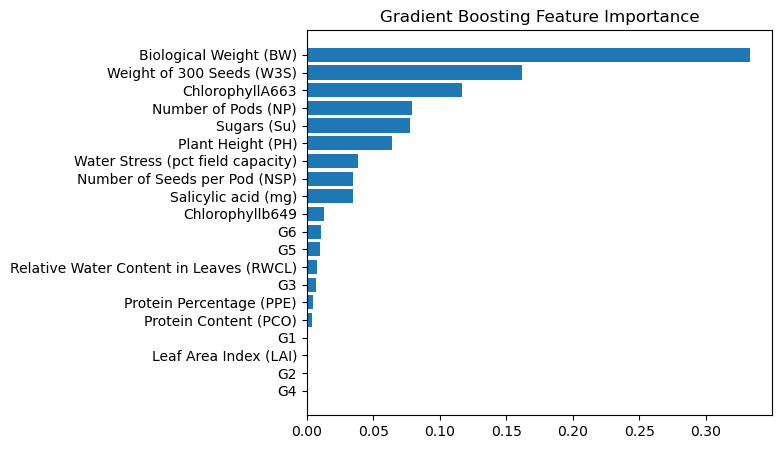

Top 5 features: ['Sugars (Su)' 'Number of Pods (NP)' 'ChlorophyllA663'
 'Weight of 300 Seeds (W3S)' 'Biological Weight (BW)']
Top 5 Features MLP Test MSE: 1408.6150
Top 5 Features MLP Test R² Score: 0.9991


In [12]:
# Step 1: Define the function from the assignment
def feature_importance_score_cal(train_X, train_y, test_X, test_y, feature_names):
    params = {
        'n_estimators': 400,
        'learning_rate': 0.1,
        'max_depth': 3,
        'subsample': 0.7
    }
    
    gbr = GradientBoostingRegressor(**params, random_state=42)
    gbr.fit(train_X, train_y)

    test_mse = mean_squared_error(test_y, gbr.predict(test_X))
    test_r2 = r2_score(test_y, gbr.predict(test_X))
    print(f"Gradient Boosting test set gives MSE: {test_mse:.4f} and R² score: {test_r2:.4f}")

    feature_importance_score = gbr.feature_importances_

    # Optional: Visualize
    sorted_idx = np.argsort(feature_importance_score)
    plt.figure(figsize=(6, 5))
    plt.barh(np.array(feature_names)[sorted_idx], feature_importance_score[sorted_idx])
    plt.title("Gradient Boosting Feature Importance")
    plt.show()

    return feature_importance_score

# Step 2: Get feature names (exclude target column)
feature_names = soybean_data_processed.drop(columns=[target_col]).columns.values

# Step 3: Get feature importance scores
importances = feature_importance_score_cal(train_X_regr, train_y_regr, test_X_regr, test_y_regr, feature_names)

# Step 4: Select top 5 features
top_5_indices = np.argsort(importances)[-5:]
top_5_features = feature_names[top_5_indices]
print(f"Top 5 features: {top_5_features}")

# Step 5: Reduce data to top 5 features
train_X_top5 = train_X_regr[:, top_5_indices]
test_X_top5 = test_X_regr[:, top_5_indices]

# Step 6: Standardize X and y
scaler_X = StandardScaler()
train_X_top5_scaled = scaler_X.fit_transform(train_X_top5)
test_X_top5_scaled = scaler_X.transform(test_X_top5)

scaler_y = StandardScaler()
train_y_scaled = scaler_y.fit_transform(train_y_regr.reshape(-1, 1)).ravel()

# Step 7: Train MLP on reduced features
mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, activation='relu', random_state=42)
mlp.fit(train_X_top5_scaled, train_y_scaled)

# Step 8: Evaluate (inverse transform prediction)
y_pred_scaled = mlp.predict(test_X_top5_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

mse = mean_squared_error(test_y_regr, y_pred)
r2 = r2_score(test_y_regr, y_pred)

print(f"Top 5 Features MLP Test MSE: {mse:.4f}")
print(f"Top 5 Features MLP Test R² Score: {r2:.4f}")


In [13]:
#Again to get the final model before saving (based on previos grid search)
# Scale X and y on all features
scaler_X = StandardScaler()
train_X_scaled = scaler_X.fit_transform(train_X_regr)
test_X_scaled = scaler_X.transform(test_X_regr)

scaler_y = StandardScaler()
train_y_scaled = scaler_y.fit_transform(train_y_regr.reshape(-1, 1)).ravel()

# Train final MLP on full feature set
final_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, activation='relu', random_state=42)
final_model.fit(train_X_scaled, train_y_scaled)

# Evaluate
y_pred_scaled = final_model.predict(test_X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

test_mse = mean_squared_error(test_y_regr, y_pred)
test_r2 = r2_score(test_y_regr, y_pred)

print(f"Final model (all features) MSE: {test_mse:.4f}")
print(f"Final model (all features) R² Score: {test_r2:.4f}")

Final model (all features) MSE: 0.0009
Final model (all features) R² Score: 1.0000


### 2.4 External Testing (3 Marks)
Develop a robust scikit-learn MLP model for soybean production prediction, and submit it along with your notebook and report. It will be run and evaluated on a test set containing soybean instances unseen by you. **Please note that the unseen dataset may contain noisy or missing features. Your model should be able to handle such cases.** Hint: you may want to experiment with model hyperparameters and data processing. You may find the sklearn module [pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline) useful when saving your completed model.

**Important: set your university username (e.g. mbxxabc3) below when saving your model.** Failure to do this correctly would lead to your model not being marked!

import model_eval_utils

#### SAVE YOUR MODEL
student_username = "h34831dj" # SET YOUR USERNAME HERE
model = final_model # SET YOUR MODEL HERE
model_eval_utils.save_model(student_username, model)

In [15]:
print(f"Total notebook run time: {time.time() - notebook_start_time:.0f} seconds")

Total notebook run time: 8000 seconds


#### Option to test your saved model
Use the `run_model()` function to make sure your saved model can be loaded and run before submitting.

**Disclaimers:** Please note the score returned by `run_model()` is not in any way indicative of your final mark. This is just a simple test to make sure your model can be loaded and run, though there is no guarantee that your model will run on the unseen data just because it can be run here. When testing your model, the GTA will run your model following the practice below, but replacing the bunk_data with the unseen data.

In [16]:
# some random data from the training set
bunk_sample_indices = np.random.choice(train_X_regr.shape[0], size=3, replace=False)
# Extract the selected rows
bunk_sampled_X = train_X_regr[bunk_sample_indices]
bunk_sampled_y = train_y_regr[bunk_sample_indices]

score = model_eval_utils.run_model(student_username,
                                test_data=bunk_sampled_X,
                                test_labels=bunk_sampled_y,
                                model_folder=".")

Attempting to load from ....
Loaded .\h34831dj.sav model.
Model score: -7.989021075353916


I apologize in advance for the long length of my report, but I am a really big fan of Machine Learning and its theoretical and mathematical fundamentals, and I truly wanted to express that in this project. :) Thank you!

### 2.5 Report (5 Marks)
1. Draw conclusions from your model selection results obtained in Section 2.2, based on factors like prediction accuracy, training efficiency, and model complexity. (*2 marks*)
2. Describe the design process of your selection and validation methods used in Section 2.3, and discuss your observations from your validation experiment. (*2 marks*)
3. Describe the methods you have used to address missing and noisy features in Section 2.4. (*1 mark*)